In [ ]:
#------------------------------ Reading Libraries ---------------------------------------------

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import cv2
import os

In [6]:
import cv2

In [7]:
cv2.__version__

'4.5.1'

In [2]:
tf.keras.backend.clear_session()

In [ ]:
Accuracy, 
Confusion Matrix, 
F1 Score,
ROC-AUC Score 

In [ ]:
# ----------------------------- Data Filtering and Preprocessing --------------------------------------------

In [3]:
categories = ['beagle', 'chihuahua', 'doberman',
'french_bulldog', 'golden_retriever', 
 'malamute', 'pug', 'saint_bernard',
 'scottish_deerhound','tibetan_mastiff']

In [2]:
csvFile = pd.read_csv('labels.csv')

In [4]:
imagesNames = {}
for label in categories:
    imagesNames[label] = np.where(csvFile['breed'].to_numpy()== label)[0]

In [5]:
names = list(imagesNames.keys())
values = [len(imagesNames[key]) for key in imagesNames.keys()]

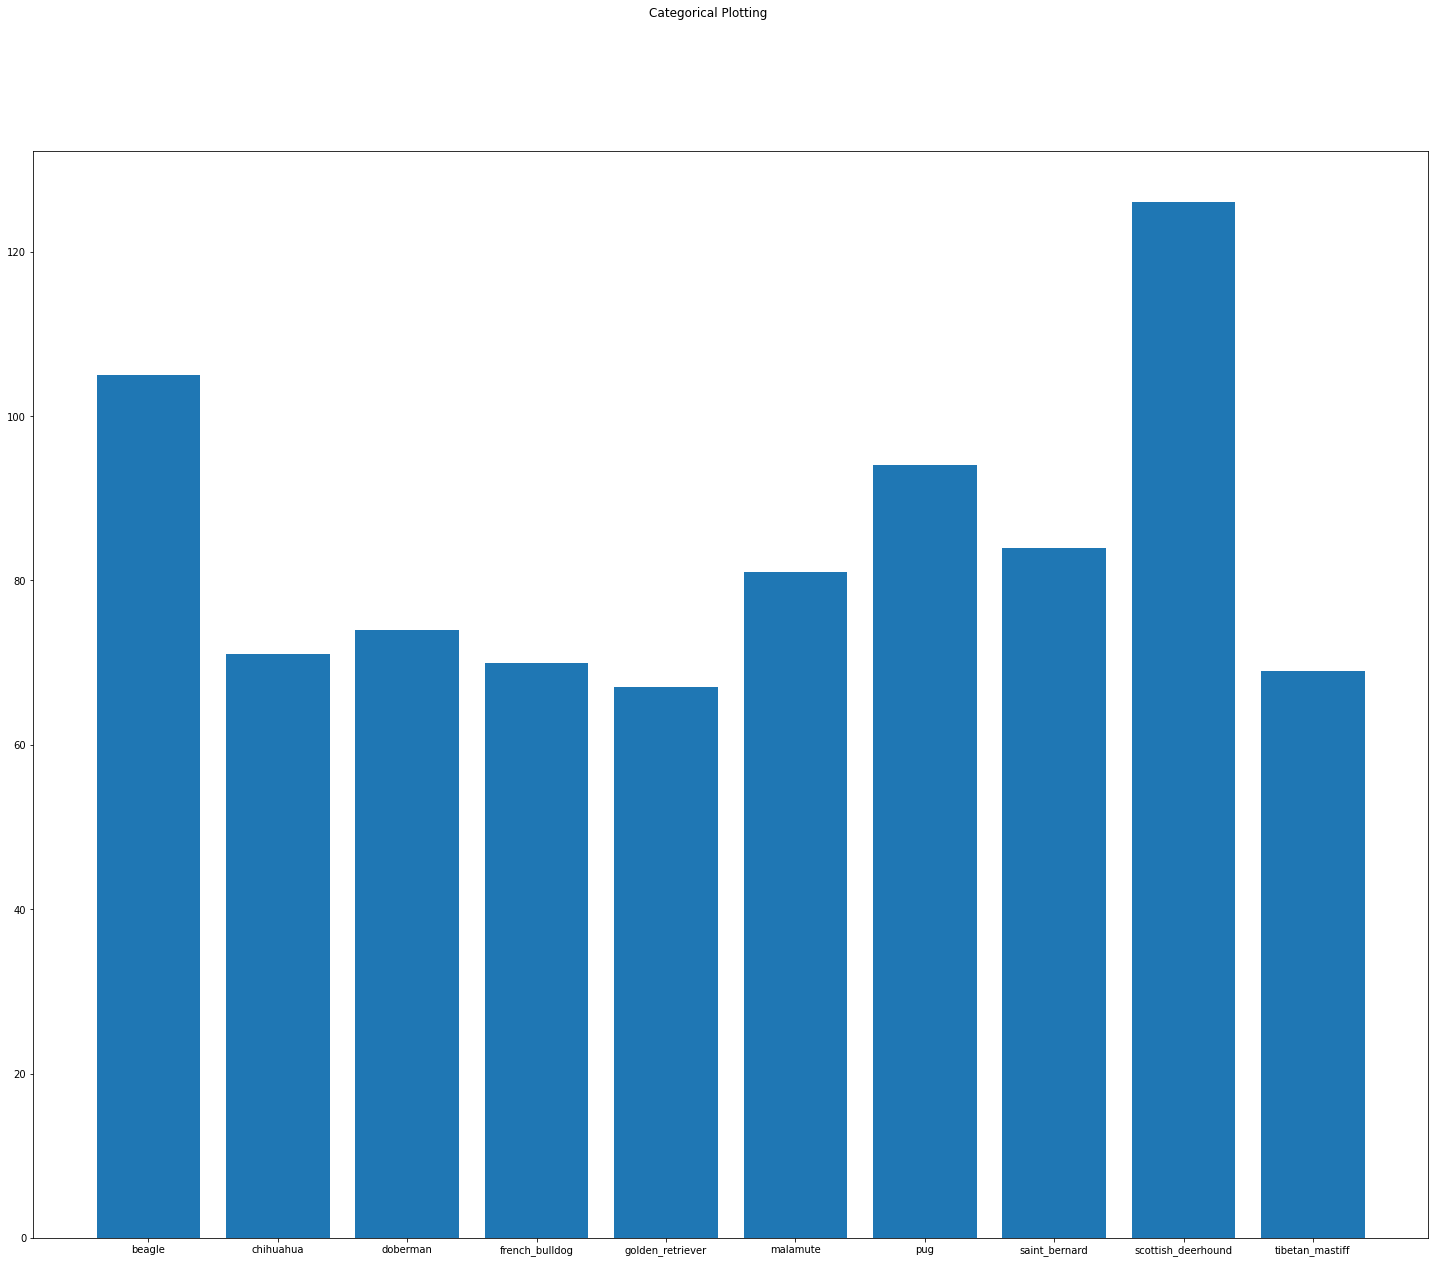

In [6]:
# Plotting number of samples per class in training dataset 


def plotCategories(categories,values):
    fig, axs = plt.subplots(1, 1, figsize=(25, 20))
    axs.bar(categories, values)
    fig.suptitle('Categorical Plotting')
    plt.show()
plotCategories(names,values)

In [7]:
labels=[]
imagesPaths = []

In [8]:
for key in imagesNames.keys():
    imagesPaths.extend(csvFile['id'][imagesNames[key]].to_list()) 
    labels.extend([key]*len(imagesNames[key]))

In [9]:
mapIndexPosition = list(zip(imagesPaths, labels))
random.shuffle(mapIndexPosition)
Data, Labels = zip(*mapIndexPosition)

In [10]:
# Splitting Data for training and Testing respectively

xtrain , xtest , ytrain , ytest = Data[:750],Data[750:],Labels[:750],Labels[750:]

In [ ]:
============================ Model creation  ===========================================

In [5]:
if os.path.exists('my_model.h5'):
    model = tf.keras.models.load_model('my_model.h5')
    print(model.summary())
else:
    baseModel = tf.keras.applications.resnet50.ResNet50(weights='imagenet',include_top=True,input_shape=(224,224,3))
    for layer in baseModel.layers:
        layer.trainable = False
    x = tf.keras.layers.Dense(len(categories),activation='softmax')(baseModel.layers[-2].output)
    model = tf.keras.models.Model(inputs = baseModel.input, outputs = x)

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [4]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [53]:
print('Model Summary : {}'.format(model.summary()))

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

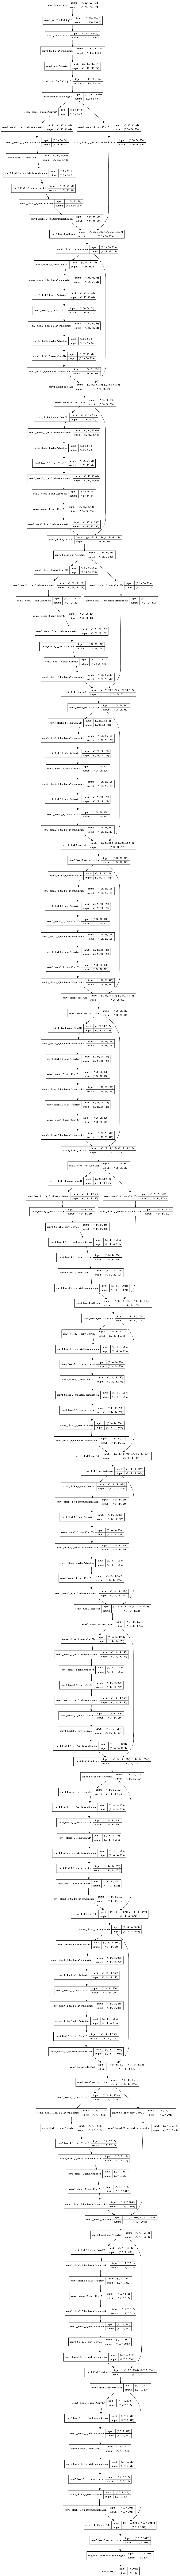

In [54]:
tf.keras.utils.plot_model(model,show_layer_names=True,show_shapes=True)

In [65]:
#=============================  Data Generator ===============================

In [23]:
def traingenerator(data, label, batch_size=4, shape=(256,256)):
    count=0
    while True: 
        batchData = []
        batchLabel = []
        if count>=len(xtrain)-5:
            count=0
        for i in range(batch_size):
            path = 'train/'+xtrain[count]+'.jpg'
            img = cv2.resize(cv2.imread(path),(256,256))
            #img = img / 255.0
            batchData.append(img)
            batchLabel.append(categories.index(ytrain[count]))
            count+=1
            
        batchData =  np.array(batchData,dtype=np.float32)
        batchLabel = np.array(batchLabel)
        if len(batchLabel) != batch_size or len(batchData) != batch_size:
            print(count)
            continue
        yield batchData,batchLabel


In [24]:
trainGen = traingenerator(xtrain,ytrain)
#testGen  = generator(xtest,ytest)

In [ ]:
# ----------------- Data Preprocessing ------------------------------------------------

In [12]:
testData = []
for image in xtest:
    testData.append(cv2.resize(cv2.imread('train/'+image+'.jpg'),(224,224)))
testData = np.array(testData)
    
trainData = []
for image in xtrain:
    trainData.append(cv2.resize(cv2.imread('train/'+image+'.jpg'),(224,224)))
trainData = np.array(trainData)

In [13]:
trainLabel = []
for l in ytrain:
    trainLabel.append(categories.index(l))
trainLabel = np.array(trainLabel)


testLabel=[]
for l in ytest:
    testLabel.append(categories.index(l))
testLabel = np.array(testLabel)

In [14]:
# --------- Creating Image Data Generator for on the fly data augmentation --------------------------


traingen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest",
        vertical_flip=True)

In [ ]:
#  ---------------- Model Training ------------------------------------------

In [21]:
model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(),metrics=["accuracy"])

In [22]:
model.fit_generator(traingen.flow(trainData,trainLabel,batch_size=8 ),validation_data=(testData,testLabel), epochs=50)

Epoch 1/50
94/94 [==============================] - 11s 117ms/step - loss: 1.6408 - accuracy: 0.4880 - val_loss: 0.4371 - val_accuracy: 0.8791
Epoch 2/50
94/94 [==============================] - 8s 89ms/step - loss: 0.6767 - accuracy: 0.7773 - val_loss: 0.2750 - val_accuracy: 0.9121
Epoch 3/50
94/94 [==============================] - 8s 89ms/step - loss: 0.5307 - accuracy: 0.8187 - val_loss: 0.2530 - val_accuracy: 0.9231
Epoch 4/50
94/94 [==============================] - 8s 89ms/step - loss: 0.3628 - accuracy: 0.8747 - val_loss: 0.2385 - val_accuracy: 0.9231
Epoch 5/50
94/94 [==============================] - 8s 89ms/step - loss: 0.3465 - accuracy: 0.8920 - val_loss: 0.2226 - val_accuracy: 0.9451
Epoch 6/50
94/94 [==============================] - 8s 89ms/step - loss: 0.3269 - accuracy: 0.9000 - val_loss: 0.2094 - val_accuracy: 0.9451
Epoch 7/50
94/94 [==============================] - 8s 89ms/step - loss: 0.2940 - accuracy: 0.9053 - val_loss: 0.1812 - val_accuracy: 0.9451
Epoch 8/50


In [38]:
def plotlist(data):
    plotData = {}
    for label in categories:
        plotData[label] = 0
    for label in data:
        plotData[categories[label]]=plotData[categories[label]]+1
    return plotData

In [39]:
print(plotlist(yData))

{'beagle': 15, 'chihuahua': 4, 'doberman': 4, 'french_bulldog': 5, 'golden_retriever': 11, 'malamute': 11, 'pug': 12, 'saint_bernard': 11, 'scottish_deerhound': 11, 'tibetan_mastiff': 7}


In [ ]:
#          --------------------- Making Predictions -----------------------------------------

In [23]:
predicted = []
confidence = []
for i in range(len(Data)):
    print(i)
    img = cv2.resize(cv2.imread('train/'+Data[i]+'.jpg'),(224,224))
    pred = model.predict(np.expand_dims(img,axis=0))
    predicted.append(categories[np.argmax(pred)])
    confidence.append(np.max(pred))
    original = Labels[i]
    print(predicted[i],confidence[i],Labels[i])
    #plt.imshow(image)
    #plt.title(predicted+" "+original)

0
pug 0.99998665 pug
1
golden_retriever 0.9999896 golden_retriever
2
golden_retriever 0.99942315 golden_retriever
3
malamute 0.99933714 malamute
4
chihuahua 0.9993892 chihuahua
5
scottish_deerhound 0.99999964 scottish_deerhound
6
golden_retriever 0.9999207 golden_retriever
7
pug 0.68240345 french_bulldog
8
pug 1.0 pug
9
pug 1.0 pug
10
malamute 0.94679785 malamute
11
pug 0.99992335 pug
12
saint_bernard 0.99999857 saint_bernard
13
malamute 0.99976903 malamute
14
beagle 0.9999933 beagle
15
tibetan_mastiff 0.9999889 tibetan_mastiff
16
beagle 0.995023 beagle
17
pug 0.9999981 pug
18
pug 0.9999975 pug
19
beagle 0.9949161 beagle
20
french_bulldog 0.79746246 french_bulldog
21
scottish_deerhound 0.9995055 scottish_deerhound
22
pug 0.99999714 pug
23
tibetan_mastiff 0.9954092 tibetan_mastiff
24
tibetan_mastiff 0.99948007 tibetan_mastiff
25
scottish_deerhound 1.0 scottish_deerhound
26
golden_retriever 0.9999887 golden_retriever
27
beagle 0.99999416 beagle
28
saint_bernard 0.9999013 saint_bernard
29

pug 1.0 pug
231
saint_bernard 0.99998665 saint_bernard
232
pug 0.9999865 pug
233
tibetan_mastiff 0.99978775 tibetan_mastiff
234
beagle 0.9999964 beagle
235
malamute 0.99996305 malamute
236
doberman 1.0 doberman
237
malamute 0.9679472 malamute
238
malamute 0.97481537 malamute
239
chihuahua 0.9999459 chihuahua
240
beagle 0.9937265 beagle
241
chihuahua 0.9908544 chihuahua
242
pug 0.9999944 pug
243
doberman 0.9997079 doberman
244
doberman 1.0 doberman
245
saint_bernard 0.99998975 saint_bernard
246
beagle 0.9999989 beagle
247
tibetan_mastiff 0.9999666 tibetan_mastiff
248
pug 0.99492764 french_bulldog
249
scottish_deerhound 0.9997943 scottish_deerhound
250
pug 0.9999993 pug
251
malamute 0.99994385 malamute
252
saint_bernard 0.999977 saint_bernard
253
chihuahua 0.9996586 chihuahua
254
pug 1.0 pug
255
saint_bernard 0.961364 saint_bernard
256
doberman 0.9999999 doberman
257
scottish_deerhound 0.9978282 scottish_deerhound
258
golden_retriever 0.99999976 golden_retriever
259
doberman 0.9998047 do

scottish_deerhound 1.0 scottish_deerhound
455
tibetan_mastiff 0.8722226 tibetan_mastiff
456
scottish_deerhound 0.999151 scottish_deerhound
457
golden_retriever 0.8917439 golden_retriever
458
malamute 0.9999999 malamute
459
saint_bernard 0.9999958 saint_bernard
460
chihuahua 0.99603444 chihuahua
461
tibetan_mastiff 0.9999355 tibetan_mastiff
462
beagle 0.9997595 beagle
463
french_bulldog 0.9399378 french_bulldog
464
tibetan_mastiff 0.9998529 tibetan_mastiff
465
beagle 0.9951865 beagle
466
scottish_deerhound 0.98867655 scottish_deerhound
467
doberman 1.0 doberman
468
malamute 0.9932706 malamute
469
saint_bernard 0.9998147 saint_bernard
470
beagle 0.99999976 beagle
471
scottish_deerhound 1.0 scottish_deerhound
472
scottish_deerhound 1.0 scottish_deerhound
473
beagle 0.99999535 beagle
474
saint_bernard 0.9999038 saint_bernard
475
golden_retriever 0.99870634 golden_retriever
476
beagle 0.9903623 beagle
477
beagle 0.9999856 beagle
478
french_bulldog 0.9893873 french_bulldog
479
saint_bernard 

scottish_deerhound 0.9999906 scottish_deerhound
673
beagle 0.9999887 beagle
674
beagle 0.99999857 beagle
675
beagle 0.99999917 beagle
676
malamute 0.99993765 malamute
677
tibetan_mastiff 0.99631315 tibetan_mastiff
678
scottish_deerhound 0.99998975 scottish_deerhound
679
pug 1.0 pug
680
pug 1.0 pug
681
chihuahua 0.99999166 chihuahua
682
scottish_deerhound 0.9999994 scottish_deerhound
683
saint_bernard 0.9999924 saint_bernard
684
malamute 0.99999976 malamute
685
pug 0.99999964 pug
686
doberman 0.99974304 doberman
687
pug 0.999962 pug
688
golden_retriever 0.99997485 golden_retriever
689
chihuahua 0.99999833 chihuahua
690
malamute 0.9996208 malamute
691
beagle 1.0 beagle
692
beagle 0.998901 beagle
693
saint_bernard 0.9999888 saint_bernard
694
scottish_deerhound 1.0 scottish_deerhound
695
scottish_deerhound 0.9999999 scottish_deerhound
696
scottish_deerhound 0.9999993 scottish_deerhound
697
tibetan_mastiff 0.99745435 tibetan_mastiff
698
golden_retriever 0.99999976 golden_retriever
699
frenc

In [34]:
model.save('my_model.h5')

In [29]:
LabelsArray = np.array(Labels)
predictedArray = np.array(predicted)

In [41]:
#===================================  Comparision METRCES  =========================

In [31]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

In [49]:
np.expand_dims(LabelsArray,axis=-1).shape,np.expand_dims(np.array(confidence),axis=-1).shape

((841, 1), (841, 1))

In [40]:
f1_score(Labels,predicted,average='micro')

0.9690844233055886

In [33]:
cm = confusion_matrix(LabelsArray, predictedArray, labels=categories)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=categories)

In [37]:
print(cm)

[[104   0   0   0   0   0   1   0   0   0]
 [  0  69   0   0   0   0   1   0   1   0]
 [  0   0  73   0   0   1   0   0   0   0]
 [  0   3   0  50   0   0  17   0   0   0]
 [  0   0   0   0  67   0   0   0   0   0]
 [  0   0   0   0   0  80   1   0   0   0]
 [  0   0   0   0   0   0  94   0   0   0]
 [  0   0   0   0   0   0   0  84   0   0]
 [  0   0   0   0   0   0   1   0 125   0]
 [  0   0   0   0   0   0   0   0   0  69]]


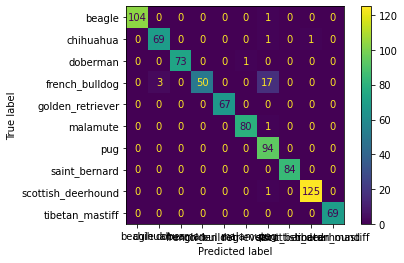

In [36]:
disp.plot()